#  STOCK PRICE PREDICTION OF GOOGLE DATA USING LSTM MODEL

In [21]:
#Import libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import string
import pandas as pd 
from google.colab import drive
import math, time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from sklearn.model_selection import train_test_split


In [22]:
drive.mount('/content/drive')
!ls '/content/drive/My Drive/DeepLearning_2022/FinalProject/Data/'
path = '/content/drive/My Drive/DeepLearning_2022/FinalProject/Data/'
path_results = '/content/drive/My Drive/DeepLearning_2022/FinalProject/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AMAZON.csv  DownloadData.ipynb	GOOGLE.csv


## LOAD AND VISUALIZE DATA

In [23]:
#Read Google dataset 
raw_data = pd.read_csv(path+'GOOGLE.csv', parse_dates=True, index_col=0)
raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065
2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031925
2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987226
2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876685
2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9484016


In [24]:
raw_data.info() #not null data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


We collected the data for 10 years (from 01 January 2010 to 01 January 2020) and have 2516 instances in the dataset. We can observe that there is non-null values in our dataset and the most of the feature are float except Volume that is an integer and the date that is an object. We will explain the meaining of the features of the dataset:


*   Date: It is the date of the observation
*   Open: Raw stock values when the market opened.
*   High: Highest stock value in that date.
*   Low: Lowest stock value in that date.
*   Close: Raw stock values when the market closed.
*   Adj Close: Estimated stock values after the market closes.
*   Volume: Number of shares traded. 

We are going to work with the stock values when the market closed, the feature *Close*.


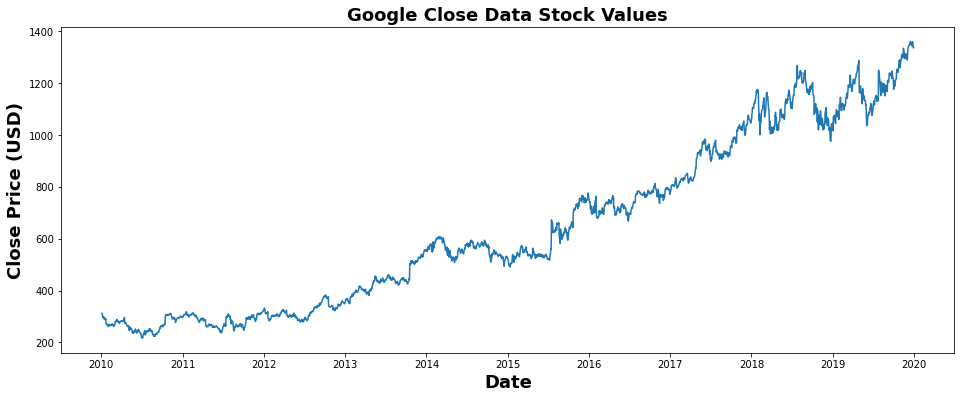

In [25]:
#Visualize the close price
plt.figure(figsize = (16,6))
plt.title('Google Close Data Stock Values', fontsize = 18,fontweight = "bold")
plt.plot(raw_data['Close'])
plt.xlabel("Date" , fontsize = 18,fontweight = "bold")
plt.ylabel("Close Price (USD)", fontsize = 18,fontweight = "bold")

plt.show()

<function matplotlib.pyplot.show>

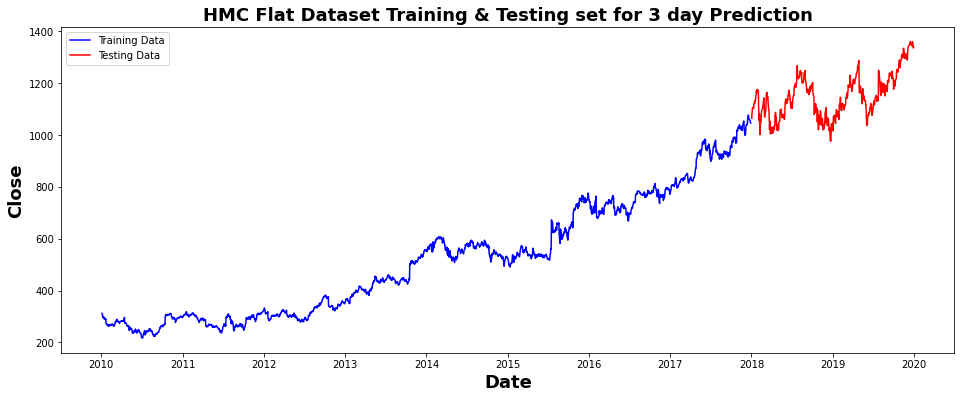

In [26]:
#Visualize the train and test set 
training_size = int(np.round(raw_data.shape[0] * 0.8))

training = raw_data.iloc[:training_size,:]
testing = raw_data.iloc[training_size:,:]

plt.figure(figsize = (16,6))
ax = plt.axes()

plt.title('HMC Flat Dataset Training & Testing set for 3 day Prediction', fontsize = 18,fontweight = "bold")
plt.xlabel('Date' , fontsize = 18,fontweight = "bold")
plt.ylabel('Close', fontsize = 18,fontweight = "bold")
plt.plot(training['Close'], 'blue', label='Training Data')
plt.plot(testing['Close'], 'red', label='Testing Data')

plt.legend()
plt.show

## NORMALIZE AND SPLIT DATA INTO TRAIN AND TEST DATASET

In [27]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# we work only with close values
df_google = raw_data.filter(items=['Close'])

#Normalize data between -1 and 1 
df_google["Close"]= scaler.fit_transform(df_google["Close"].values.reshape(-1,1))
df_google

,Close
Date,
2010-01-04,-0.833937
2010-01-05,-0.836340
2010-01-06,-0.850040
2010-01-07,-0.862372
2010-01-08,-0.855474
...,...
2019-12-24,0.969212
2019-12-26,0.998654
2019-12-27,0.983775


In [28]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    x = []
    
    for index in range(len(data_raw) - look_back): 
        x.append(data_raw[index : index + look_back])
    
    x = np.array(x)  

    # 80% train 20% test
    test_set_size = int(np.round(0.2*x.shape[0]))
    train_set_size = x.shape[0] - (test_set_size)
    x_train = x[:train_set_size,:-1]
    y_train = x[:train_set_size,-1]

    x_test = x[train_set_size:,:-1]
    y_test = x[train_set_size:,-1]

    
    return [x_train, y_train, x_test, y_test]


look_back = 30 #Choose sequence length


x_train, y_train, x_test, y_test = load_data(df_google, look_back)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1989, 29, 1)
y_train.shape =  (1989, 1)
x_test.shape =  (497, 29, 1)
y_test.shape =  (497, 1)


In [29]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Create the MLP model 

In [31]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        

        out = self.fc(out[:, -1, :]) 
       

        return out

We define the model, loss function and hyperparameters

In [32]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

## Train and Testing

Epoch  0 MSE:  0.34167754650115967
Epoch  1 MSE:  0.15558822453022003
Epoch  2 MSE:  0.3595340847969055
Epoch  3 MSE:  0.25532639026641846
Epoch  4 MSE:  0.2494746744632721
Epoch  5 MSE:  0.14809951186180115
Epoch  6 MSE:  0.1317952275276184
Epoch  7 MSE:  0.10292817652225494
Epoch  8 MSE:  0.09228141605854034
Epoch  9 MSE:  0.08292500674724579
Epoch  10 MSE:  0.0642591267824173
Epoch  11 MSE:  0.021677056327462196
Epoch  12 MSE:  0.06711536645889282
Epoch  13 MSE:  0.022687632590532303
Epoch  14 MSE:  0.013077779673039913
Epoch  15 MSE:  0.025638828054070473
Epoch  16 MSE:  0.02663826011121273
Epoch  17 MSE:  0.016554513946175575
Epoch  18 MSE:  0.008081909269094467
Epoch  19 MSE:  0.0075026266276836395
Epoch  20 MSE:  0.01141325756907463
Epoch  21 MSE:  0.011424172669649124
Epoch  22 MSE:  0.008980128914117813
Epoch  23 MSE:  0.00530365901067853
Epoch  24 MSE:  0.00391570245847106
Epoch  25 MSE:  0.004665812477469444
Epoch  26 MSE:  0.005613491404801607
Epoch  27 MSE:  0.005692196544

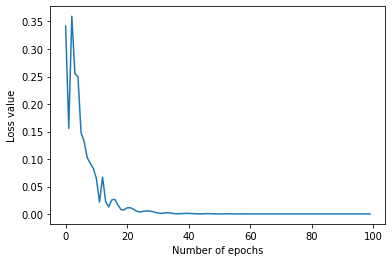

In [33]:
#Trainig the model 
loss_lstm = [] 
model.train() #active train mode

for iter in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", iter, "MSE: ", loss.item())

    loss_lstm.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(loss_lstm)
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.show()

Text(0, 0.5, 'Close Price (USD)')

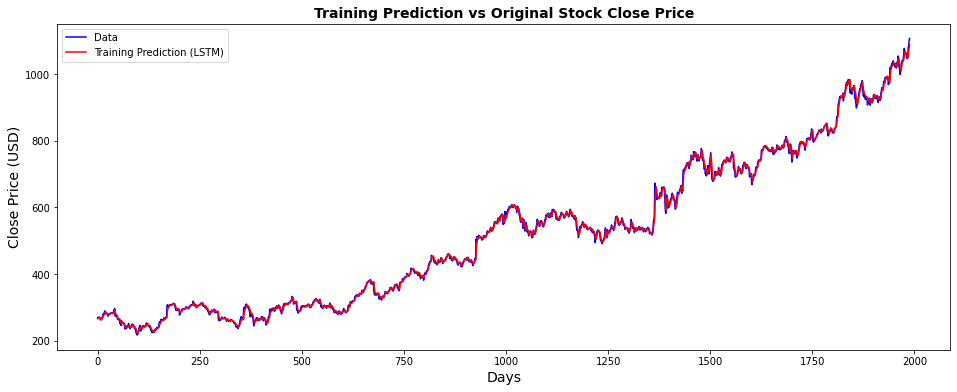

In [34]:
#Visualize the training predictions

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

plt.figure(figsize = (16,6))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Training Prediction vs Original Stock Close Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close Price (USD)", size = 14)


In [35]:
#Testing the model 

# make predictions
model.eval()
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

Text(0, 0.5, 'Close Price (USD)')

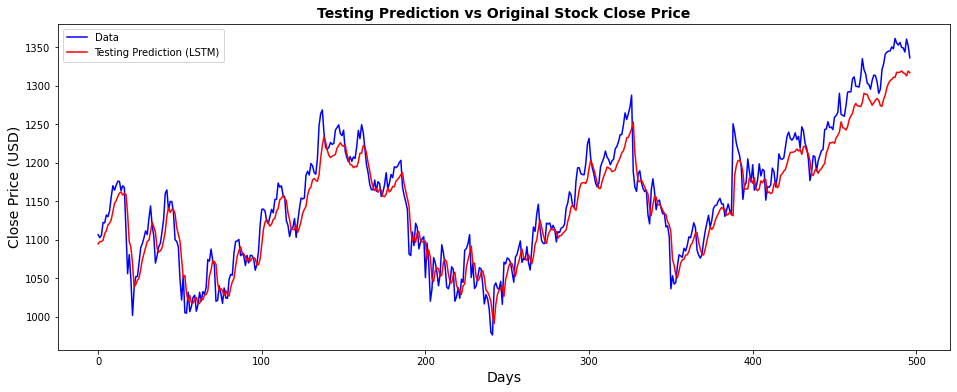

In [36]:
#Visualize the testing predictions
original =  pd.DataFrame(y_test)
predict =  pd.DataFrame(y_test_pred)

plt.figure(figsize = (16,6))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Testing Prediction (LSTM)", color='red')
ax.set_title('Testing Prediction vs Original Stock Close Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close Price (USD)", size = 14)


## VISUALIZE RESULTS

In [37]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_google)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_google)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_google)-1, :] = y_test_pred

original = scaler.inverse_transform(df_google['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [38]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

loss_lstm.append(trainScore)
loss_lstm.append(testScore)

Train Score: 8.67 RMSE
Test Score: 24.40 RMSE


In [41]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value',
                    )))
fig.update_layout(
    xaxis=dict(
        title_text='Days',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly_white'

)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM) GOOGLE',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='black'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [40]:
result_LSTM_GOOGLE= result.set_index(raw_data.index)
result_LSTM_GOOGLE.to_csv(path_results+'result_LSTM_GOOG.csv')
result_LSTM_GOOGLE.head()

,0,1,2
Date,,,
2010-01-04,NaN,NaN,312.204773
2010-01-05,NaN,NaN,310.829926
2010-01-06,NaN,NaN,302.994293
2010-01-07,NaN,NaN,295.940735
2010-01-08,NaN,NaN,299.885956
